## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from P7_functions import dataset_overview
from P7_functions import NaN_overview
from P7_functions import feature_distribution

In [3]:
from Preprocess_Dataframe_V2 import downcast_numerical_column_V2

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [6]:
from sklearn.dummy import DummyClassifier

In [7]:
from IPython.display import display, HTML
plt.style.use('seaborn')

warnings.simplefilter(category=FutureWarning, action='ignore')
warnings.simplefilter(category=UserWarning, action='ignore')

# pour gérer l'affichage des dataframes pandas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
pd.set_option("colheader_justify", "left")

# pour gérer l'affichage des arrays numpy
# 230 sur config bureau, 165 sur config portable
np.set_printoptions(linewidth=165)

# pour afficher les gros fichiers sur toute la largeur de l'écran
HTML("<style>.container { width:95% }</style>")

# 1. Ouverture du jeu de données et préparation

## 1.1. Ouverture du jeu de données

On conserve la notation X et y pour simplifier la lecture du Notebook.<br>

In [8]:
X = pd.read_csv('X.csv', compression = 'gzip', index_col = 0)

In [9]:
X.head()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,ANNUITY_INCOME_PERC,APPROVED_AMT_ANNUITY_MAX,APPROVED_AMT_ANNUITY_MEAN,APPROVED_AMT_ANNUITY_MIN,APPROVED_AMT_APPLICATION_MAX,APPROVED_AMT_APPLICATION_MEAN,APPROVED_AMT_APPLICATION_MIN,APPROVED_AMT_CREDIT_MAX,APPROVED_AMT_CREDIT_MEAN,APPROVED_AMT_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,APPROVED_AMT_DOWN_PAYMENT_MEAN,APPROVED_AMT_DOWN_PAYMENT_MIN,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEAN,APPROVED_AMT_GOODS_PRICE_MIN,APPROVED_APP_CREDIT_PERC_MAX,APPROVED_APP_CREDIT_PERC_MEAN,APPROVED_APP_CREDIT_PERC_MIN,APPROVED_CNT_PAYMENT_MEAN,APPROVED_CNT_PAYMENT_SUM,APPROVED_DAYS_DECISION_MAX,APPROVED_DAYS_DECISION_MEAN,APPROVED_DAYS_DECISION_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_HOUR_APPR_PROCESS_START_MIN,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_RATE_DOWN_PAYMENT_MEAN,APPROVED_RATE_DOWN_PAYMENT_MIN,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_CNT_CREDIT_PROLONG_SUM,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EMERGENCYSTATE_MODE,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,INCOME_CREDIT_PERC,INCOME_PER_PERSON,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_COUNT,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_DBD_MAX,INSTAL_DBD_MEAN,INSTAL_DBD_SUM,INSTAL_DPD_MAX,INSTAL_DPD_MEAN,INSTAL_DPD_SUM,INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE,INSTAL_PAYMENT_DIFF_MAX,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_PAYMENT_DIFF_SUM,INSTAL_PAYMENT_DIFF_VAR,INSTAL_PAYMENT_PERC_MAX,INSTAL_PAYMENT_PERC_MEAN,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_PERC_VAR,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,PAYMENT_RATE,POS_COUNT,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,PREV_AMT_ANNUITY_MAX,PREV_AMT_ANNUITY_MEAN,PREV_AMT_ANNUITY_MIN,PREV_AMT_APPLICATION_MAX,PREV_AMT_APPLICATION_MEAN,PREV_AMT_APPLICATION_MIN,PREV_AMT_CREDIT_MAX,PREV_AMT_CREDIT_MEAN,PREV_AMT_CREDIT_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_AMT_DOWN_PAYMENT_MIN,PREV_AMT_GOODS_PRICE_MAX,PREV_AMT_GOODS_PRICE_MEAN,PREV_AMT_GOODS_PRICE_MIN,PREV_APP_CREDIT_PERC_MAX,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_MIN,PREV_CNT_PAYMENT_MEAN,PREV_CNT_PAYMENT_SUM,PREV_DAYS_DECISION_MAX,PREV_DAYS_DECISION_MEAN,PREV_DAYS_DECISION_MIN,PREV_HOUR_APPR_PROCESS_START_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_H

In [10]:
y = pd.read_csv('y.csv', compression = 'gzip', index_col = 0)

In [11]:
y.head()

,TARGET
299904,1.0
249970,0.0
149060,0.0
278013,0.0
221527,0.0


## 1.2. Préparation des splits train/test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

# 2. Modélisation avec DummyClassifier

## 2.1. DummyClassifier avec stratégie "most_frequent"

In [14]:
dclf = DummyClassifier(strategy="most_frequent")
dclf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [15]:
y_test_pred_proba = dclf.predict_proba(X_test)
y_train_pred_proba = dclf.predict_proba(X_train)
fpr, tpr, thr = roc_curve(y_train, y_train_pred_proba[:, 1])

In [16]:
def plot_ROC_curve(fpr, tpr, y_true, y_pred_proba, title):
    plt.figure(edgecolor='black', linewidth=4)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve",

    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title('Courbe ROC du classifieur sur le train set : ' + str(title), fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    print(str(title) + ' ROC AUC Score : ' + str(roc_auc_score(y_true, y_pred_proba[:, 1])))
    print(str(title) + ' AUC           : ' + str(auc(fpr, tpr)))

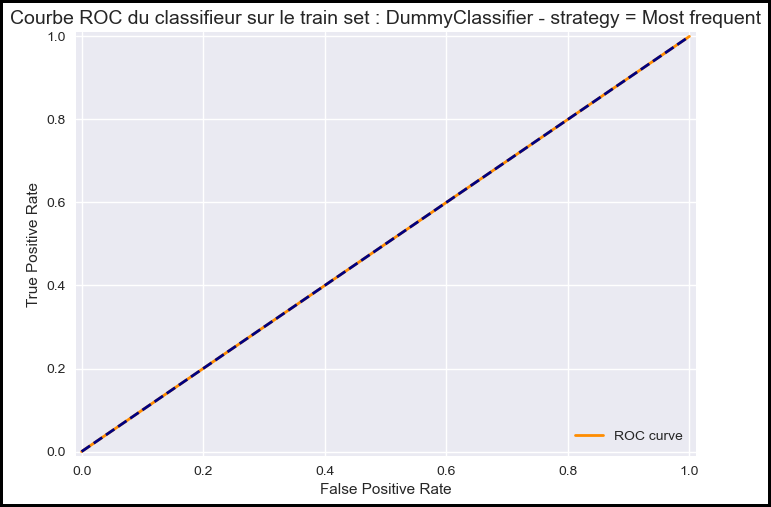

DummyClassifier - strategy = Most frequent ROC AUC Score : 0.5
DummyClassifier - strategy = Most frequent AUC           : 0.5


In [17]:
plot_ROC_curve(fpr, tpr, y_test, y_test_pred_proba, 'DummyClassifier - strategy = Most frequent')

In [18]:
from IPython.display import HTML, display
import numpy as np

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_metrics(y_true, y_pred, title):

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    F1 = f1_score(y_true, y_pred)
    
    metrics_table = '<h4 style="font-size: 20px;">{}</h4>'.format(title)
    metrics_table += '<table style="font-size: 16px;"><tr><th style="text-align: left;">Metrics</th><th>Score</th></tr>'
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_precision', precision)
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_recall', recall)
    metrics_table += '<tr><td style="text-align: left;">{}</td><td>{:.3f}</td></tr>'.format(title + '_F1', F1)
    metrics_table += '</table>'
    display(HTML(metrics_table))

In [19]:
y_test_pred = dclf.predict(X_test)

In [20]:
print_metrics(y_test, y_test_pred, 'DummyClassifier - strategy = Most frequent')

Metrics,Score
DummyClassifier - strategy = Most frequent_precision,0.000
DummyClassifier - strategy = Most frequent_recall,0.000
DummyClassifier - strategy = Most frequent_F1,0.000


## 2.2. DummyClassifier avec stratégie "uniform"

In [21]:
dclf_2 = DummyClassifier(strategy="uniform")
dclf_2.fit(X_train, y_train)

DummyClassifier(strategy='uniform')

In [22]:
y_test_pred_proba_2 = dclf_2.predict_proba(X_test)
y_train_pred_proba_2 = dclf_2.predict_proba(X_train)
fpr_2, tpr_2, thr_2 = roc_curve(y_train, y_train_pred_proba_2[:, 1])

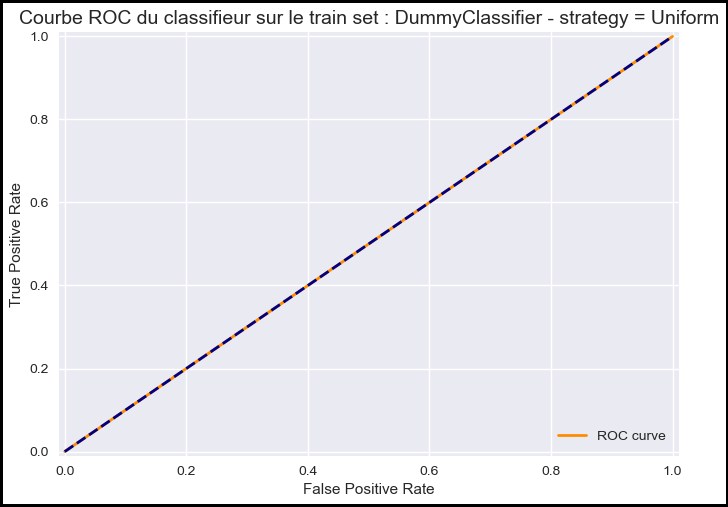

DummyClassifier - strategy = Uniform ROC AUC Score : 0.5
DummyClassifier - strategy = Uniform AUC           : 0.5


In [23]:
plot_ROC_curve(fpr_2, tpr_2, y_test, y_test_pred_proba_2, 'DummyClassifier - strategy = Uniform')

In [24]:
y_test_pred_2 = dclf_2.predict(X_test)

In [25]:
print_metrics(y_test, y_test_pred_2 , 'DummyClassifier - strategy = Uniform')

Metrics,Score
DummyClassifier - strategy = Uniform_precision,0.082
DummyClassifier - strategy = Uniform_recall,0.506
DummyClassifier - strategy = Uniform_F1,0.142


## 2.3. DummyClassifier avec stratégie "prior"

In [26]:
dclf_3 = DummyClassifier(strategy="prior")
dclf_3.fit(X_train, y_train)

DummyClassifier()

In [27]:
y_test_pred_proba_3 = dclf_3.predict_proba(X_test)
y_train_pred_proba_3 = dclf_3.predict_proba(X_train)
fpr_3, tpr_3, thr_3 = roc_curve(y_train, y_train_pred_proba_3[:, 1])

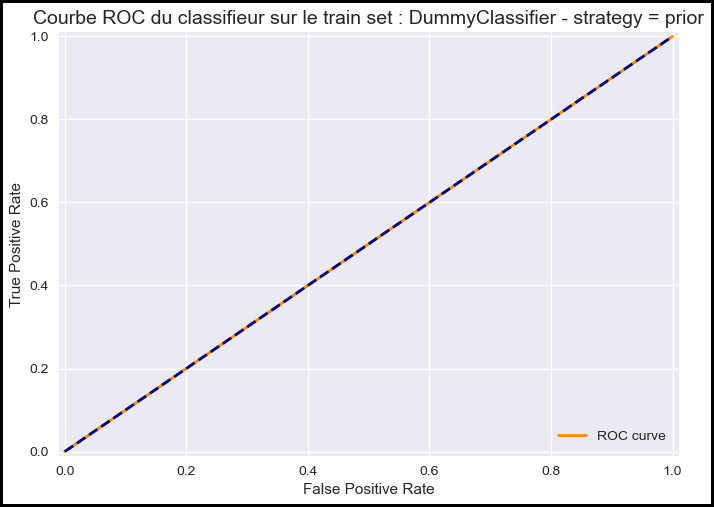

DummyClassifier - strategy = prior ROC AUC Score : 0.5
DummyClassifier - strategy = prior AUC           : 0.5


In [28]:
plot_ROC_curve(fpr_3, tpr_3, y_test, y_test_pred_proba_3, 'DummyClassifier - strategy = prior')

In [29]:
y_test_pred_3 = dclf_3.predict(X_test)

In [30]:
print_metrics(y_test, y_test_pred_3 , 'DummyClassifier - strategy = prior')

Metrics,Score
DummyClassifier - strategy = prior_precision,0.000
DummyClassifier - strategy = prior_recall,0.000
DummyClassifier - strategy = prior_F1,0.000


## Conclusion :<br>
Aucun des modèles Dummy ne convient, comme attendu.